In [1]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET

# function gets the bounding box cordinates from xml file and stores them in pandas dataframe
def xml_to_csv(path):
    """
    path; path where the images as well as the voc annotations are stored
    return a dataframe of the annotations
    """
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            bbx = member.find('bndbox')
            xmin = int(bbx.find('xmin').text)
            ymin = int(bbx.find('ymin').text)
            xmax = int(bbx.find('xmax').text)
            ymax = int(bbx.find('ymax').text)
            label = member.find('name').text

            value = (root.find('filename').text,
                     int(root.find('size')[0].text),
                     int(root.find('size')[1].text),
                     label,
                     xmin,
                     ymin,
                     xmax,
                     ymax
                     )
            xml_list.append(value)
    column_name = ['filename', 'width', 'height',
                   'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df


In [2]:
annotations=[os.path.join("Whitefly dataset",i) for i in os.listdir("Whitefly dataset") if i.endswith(".xml")]
images=[os.path.join("Whitefly dataset",i) for i in os.listdir("Whitefly dataset") if i.endswith(".jpg")]
print('Image annotations: ',len(annotations))
print('Images: ',len(images))


Image annotations:  6046
Images:  7496


In [3]:
# convert the pascal voc annotations to csv file
xml_df = xml_to_csv('Whitefly dataset/')
print('Successfully converted xml to csv.')
xml_df.to_csv(r'whitefly_annotations.csv', index = False)


Successfully converted xml to csv.


In [6]:
train_df = pd.read_csv('whitefly_annotations.csv')


In [5]:
train_df.head()

filename  width  height     class  xmin  ymin  xmax  ymax
0  IMG_20190219_011901_4.jpg   1920    4000  whitefly   544  1896   579  1933
1  IMG_20190219_011901_4.jpg   1920    4000  whitefly  1295  1951  1317  1980
2  IMG_20190219_011901_4.jpg   1920    4000  whitefly  1611  1991  1648  2020
3  IMG_20190219_021423_9.jpg   1920    4000  whitefly   303  2609   319  2621
4  IMG_20190219_021423_9.jpg   1920    4000  whitefly   316  2549   334  2568

In [6]:
train_df['width'].unique

<bound method Series.unique of 0         1920
1         1920
2         1920
3         1920
4         1920
          ... 
336277    1920
336278    1920
336279    1920
336280    1920
336281    1920
Name: width, Length: 336282, dtype: int64>

In [3]:
import os
import ast
from collections import namedtuple

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from tqdm import tqdm
from PIL import Image

import joblib
from joblib import Parallel, delayed

import cv2
import albumentations
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations.bbox_utils import denormalize_bbox, normalize_bbox


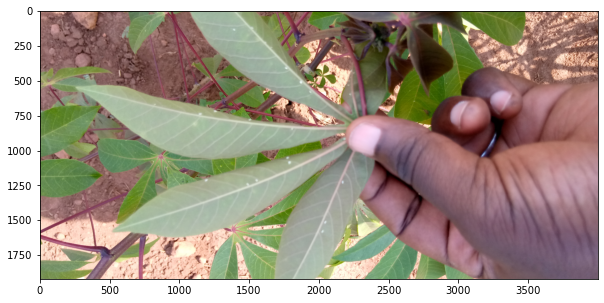

In [4]:
filename = 'IMG_20190306_051130_8.jpg'
BASE_DIR = 'Whitefly dataset/'
image = cv2.imread(os.path.join(BASE_DIR, f'{filename}'), cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
image /= 255.0
plt.figure(figsize = (10, 10))
plt.imshow(image)
plt.show()

In [13]:
image.shape

(1920, 4000, 3)

In [7]:
# obtain the xmin,ymin,xmax,ymax value for the file
pascal_voc_boxes = train_df[train_df['filename'] == filename][['xmin', 'ymin', 'xmax','ymax']].astype(np.int32).values
labels = np.ones((len(pascal_voc_boxes), ))

In [8]:
pascal_voc_boxes

array([[2124, 1184, 2200, 1256],
       [2020, 1480, 2076, 1540],
       [1992, 1556, 2084, 1632],
       [1764, 1060, 1820, 1136],
       [1740, 1016, 1816, 1092],
       [1460, 1212, 1520, 1272],
       [1516, 1180, 1588, 1264],
       [1156, 1192, 1212, 1252],
       [1120,  708, 1172,  784],
       [1224,  692, 1288,  764],
       [1464,  748, 1528,  800],
       [1912,  536, 1964,  620],
       [1836,  488, 1904,  552],
       [1736,  380, 1780,  452],
       [1368,  104, 1416,  164],
       [1496,  108, 1544,  156]], dtype=int32)

In [9]:
# obtain bounding box coordinates
def get_bbox(bboxes, col, color='white', bbox_format='pascal_voc'):
    
    for i in range(len(bboxes)):
        # Create a Rectangle patch
        if bbox_format == 'pascal_voc':
            rect = patches.Rectangle(
                (bboxes[i][0], bboxes[i][1]),
                bboxes[i][2] - bboxes[i][0], 
                bboxes[i][3] - bboxes[i][1], 
                linewidth=0.5, 
                edgecolor=color, 
                facecolor='none')
        else:
            rect = patches.Rectangle(
                (bboxes[i][0], bboxes[i][1]),
                bboxes[i][2], 
                bboxes[i][3], 
                linewidth=2, 
                edgecolor=color, 
                facecolor='none')

        # Add the patch to the Axes
        col.add_patch(rect)


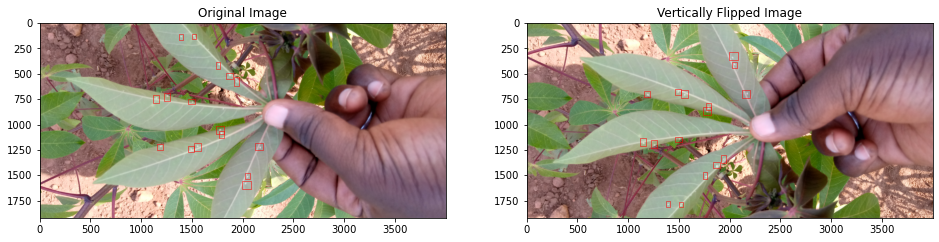

In [11]:
aug = albumentations.Compose([
   albumentations.VerticalFlip(1)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
aug_result = aug(image=image, bboxes=pascal_voc_boxes, labels=labels)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
get_bbox(pascal_voc_boxes, ax[0], color='red')
ax[0].title.set_text('Original Image')
ax[0].imshow(image)

get_bbox(aug_result['bboxes'], ax[1], color='red')
ax[1].title.set_text('Vertically Flipped Image')
ax[1].imshow(aug_result['image'])
plt.show()


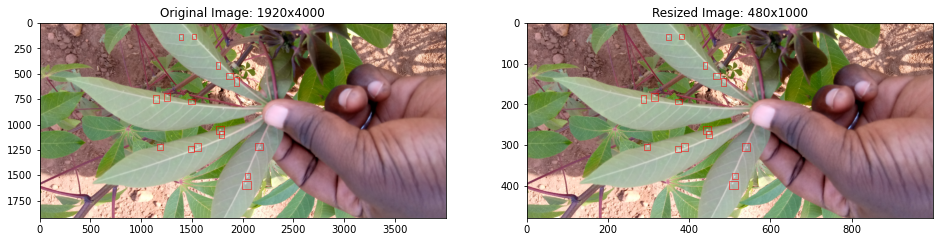

In [22]:
aug = albumentations.Compose([
       albumentations.Resize(480,1000)  # Resize the given 1920 x 4000 image to 480 X 1000

    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
aug_result = aug(image=image, bboxes=pascal_voc_boxes,min_area=300, labels=labels)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
get_bbox(pascal_voc_boxes, ax[0], color='red')
ax[0].title.set_text('Original Image: 1920x4000')
ax[0].imshow(image)

get_bbox(aug_result['bboxes'], ax[1], color='red')
ax[1].title.set_text('Resized Image: 480x1000')
ax[1].imshow(aug_result['image'])
plt.show()


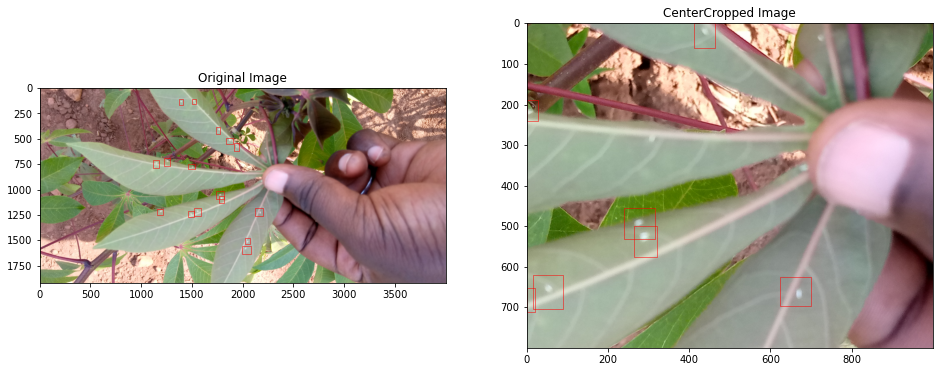

In [27]:
aug = albumentations.Compose([
    # crop the center part of the image
   albumentations.CenterCrop(800, 1000)
   ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
aug_result = aug(image=image, bboxes=pascal_voc_boxes, labels=labels)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
get_bbox(pascal_voc_boxes, ax[0], color='red')
ax[0].title.set_text('Original Image')
ax[0].imshow(image)

get_bbox(aug_result['bboxes'], ax[1], color='red')
ax[1].title.set_text('CenterCropped Image')
ax[1].imshow(aug_result['image'])
plt.show()


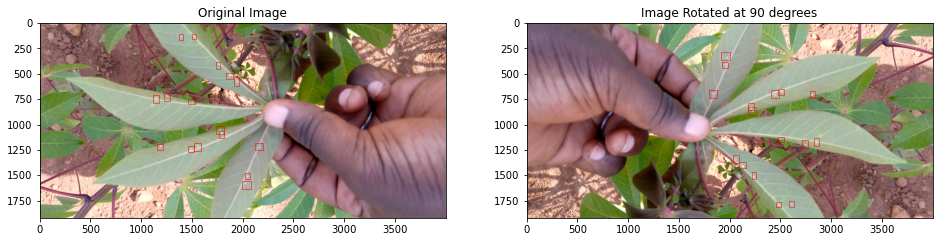

In [44]:
aug = albumentations.Compose([
    #Randomly rotate the input by 90 degrees zero or more times.
   albumentations.RandomRotate90(p=1)
 
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
aug_result = aug(image=image, bboxes=pascal_voc_boxes, labels=labels)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
get_bbox(pascal_voc_boxes, ax[0], color='red')
ax[0].title.set_text('Original Image')
ax[0].imshow(image)

get_bbox(aug_result['bboxes'], ax[1], color='red')
ax[1].title.set_text('Image Rotated at 90 degrees')
ax[1].imshow(aug_result['image'])
plt.show()


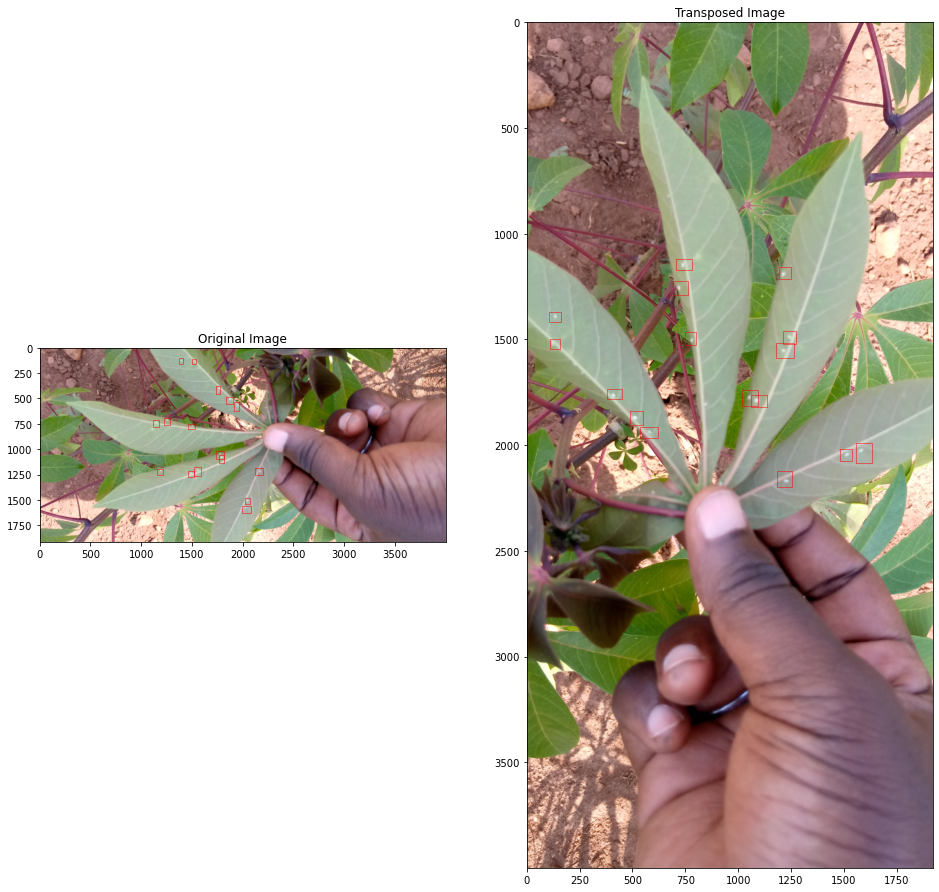

In [10]:
aug = albumentations.Compose([
   albumentations.Transpose(p=1) #Transpose input by swapping rows by columns
   ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
aug_result = aug(image=image, bboxes=pascal_voc_boxes, labels=labels)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
get_bbox(pascal_voc_boxes, ax[0], color='red')
ax[0].title.set_text('Original Image')
ax[0].imshow(image)

get_bbox(aug_result['bboxes'], ax[1], color='red')
ax[1].title.set_text('Transposed Image')
ax[1].imshow(aug_result['image'])
plt.show()


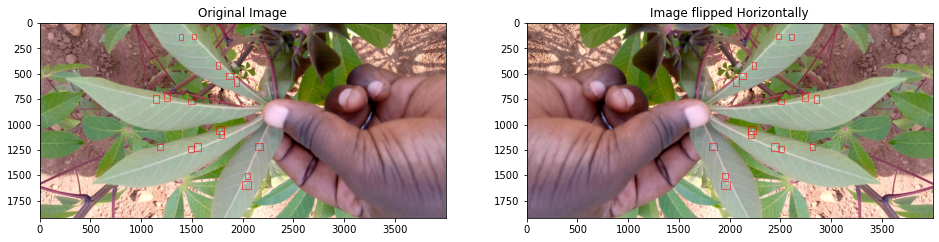

In [43]:
aug = albumentations.Compose([
   albumentations.HorizontalFlip(p=1) 
   ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
aug_result = aug(image=image, bboxes=pascal_voc_boxes, labels=labels)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
get_bbox(pascal_voc_boxes, ax[0], color='red')
ax[0].title.set_text('Original Image')
ax[0].imshow(image)

get_bbox(aug_result['bboxes'], ax[1], color='red')
ax[1].title.set_text('Image flipped Horizontally')
ax[1].imshow(aug_result['image'])
plt.show()


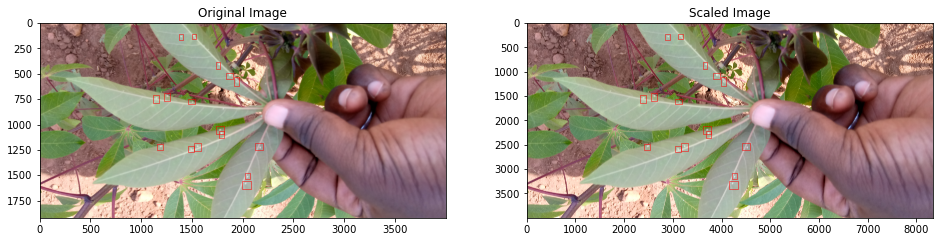

In [40]:
aug = albumentations.Compose([
   albumentations.SmallestMaxSize(
#Rescale image so that the min side is equal to the max side keeping aspect ratio of initial image
   max_size=4000,interpolation=1,p=1) 
   ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
aug_result = aug(image=image, bboxes=pascal_voc_boxes, labels=labels)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
get_bbox(pascal_voc_boxes, ax[0], color='red')
ax[0].title.set_text('Original Image')
ax[0].imshow(image)

get_bbox(aug_result['bboxes'], ax[1], color='red')
ax[1].title.set_text('Scaled Image')
ax[1].imshow(aug_result['image'])
plt.show()


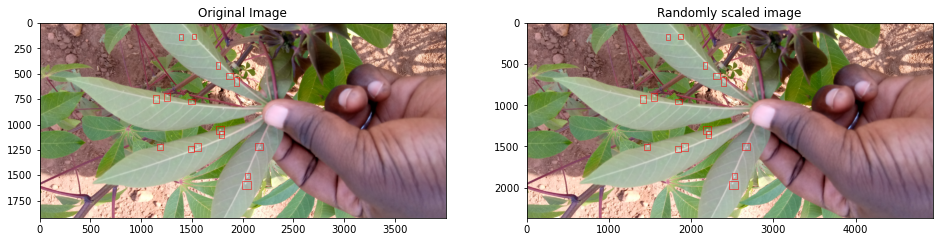

In [42]:
aug = albumentations.Compose([
   albumentations.RandomScale(
#Randomly resize the output, output size will be different from input size
 # ---> range( 1-scalelimit, 1+scalelimit)      
   scale_limit=0.6,interpolation=1,p=1) 
   ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
aug_result = aug(image=image, bboxes=pascal_voc_boxes, labels=labels)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
get_bbox(pascal_voc_boxes, ax[0], color='red')
ax[0].title.set_text('Original Image')
ax[0].imshow(image)

get_bbox(aug_result['bboxes'], ax[1], color='red')
ax[1].title.set_text('Randomly scaled image')
ax[1].imshow(aug_result['image'])
plt.show()


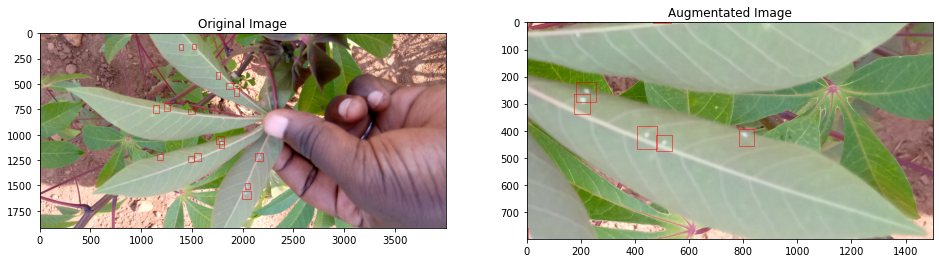

In [57]:
aug = albumentations.Compose([
   albumentations.RandomCrop(800,1500),
   albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightnessContrast(p=0.2),

   ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
aug_result = aug(image=image, bboxes=pascal_voc_boxes, labels=labels)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
get_bbox(pascal_voc_boxes, ax[0], color='red')
ax[0].title.set_text('Original Image')
ax[0].imshow(image)

get_bbox(aug_result['bboxes'], ax[1], color='red')
ax[1].title.set_text('Augmentated Image')
ax[1].imshow(aug_result['image'])
plt.show()



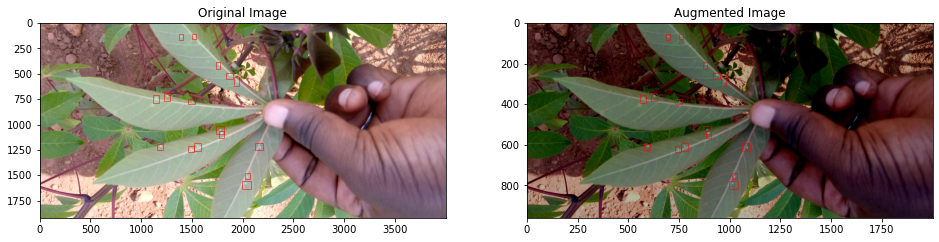

In [50]:
aug = albumentations.Compose([
        albumentations.Resize(960, 2000),   # Resize the given 1920 x 4000 image to 960* 2000   
        albumentations.PadIfNeeded(800, 800, p=1),
     albumentations.RandomBrightness(limit=0.5, p=1),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
aug_result = aug(image=image, bboxes=pascal_voc_boxes, labels=labels)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
get_bbox(pascal_voc_boxes, ax[0], color='red')
ax[0].title.set_text('Original Image')
ax[0].imshow(image)

get_bbox(aug_result['bboxes'], ax[1], color='red')
ax[1].title.set_text('Augmented Image')
ax[1].imshow(aug_result['image'])
plt.show()

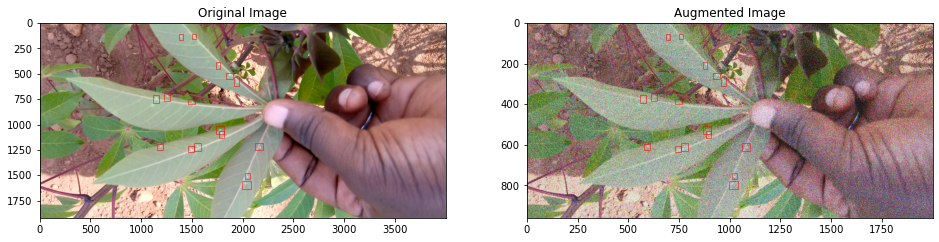

In [51]:
aug = albumentations.Compose([
      albumentations.Resize(960, 2000),   # Resize the given 1920 x 4000 image to 960* 2000   
        albumentations.GaussNoise(var_limit=(0.1, 0.1), p=1),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
aug_result = aug(image=image, bboxes=pascal_voc_boxes, labels=labels)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
get_bbox(pascal_voc_boxes, ax[0], color='red')
ax[0].title.set_text('Original Image')
ax[0].imshow(image)

get_bbox(aug_result['bboxes'], ax[1], color='red')
ax[1].title.set_text('Augmented Image')
ax[1].imshow(aug_result['image'])
plt.show()

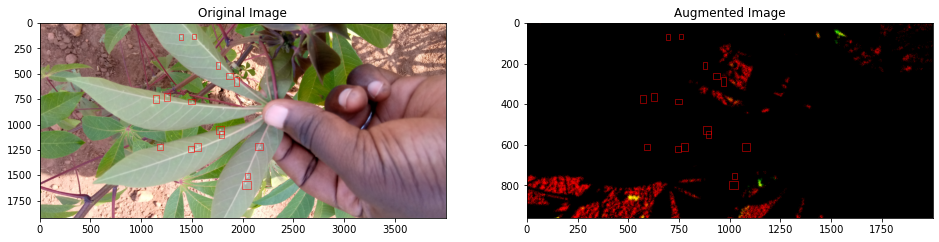

In [52]:
 
    aug = albumentations.Compose([
      albumentations.Resize(960, 2000),   # Resize the given 1920 x 4000 image to 960* 2000   
      albumentations.GlassBlur(sigma=0.1, max_delta=4, p=1),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
aug_result = aug(image=image, bboxes=pascal_voc_boxes, labels=labels)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
get_bbox(pascal_voc_boxes, ax[0], color='red')
ax[0].title.set_text('Original Image')
ax[0].imshow(image)

get_bbox(aug_result['bboxes'], ax[1], color='red')
ax[1].title.set_text('Augmented Image')
ax[1].imshow(aug_result['image'])
plt.show()

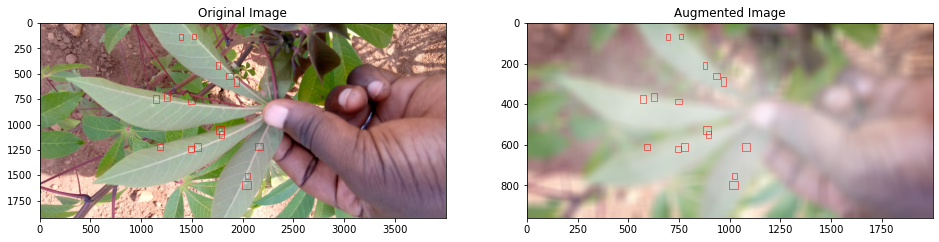

In [54]:

    aug = albumentations.Compose([
      albumentations.Resize(960, 2000),   # Resize the given 1920 x 4000 image to 960* 2000   
      albumentations.RandomFog(p=1)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
aug_result = aug(image=image, bboxes=pascal_voc_boxes, labels=labels)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
get_bbox(pascal_voc_boxes, ax[0], color='red')
ax[0].title.set_text('Original Image')
ax[0].imshow(image)

get_bbox(aug_result['bboxes'], ax[1], color='red')
ax[1].title.set_text('Augmented Image')
ax[1].imshow(aug_result['image'])
plt.show()

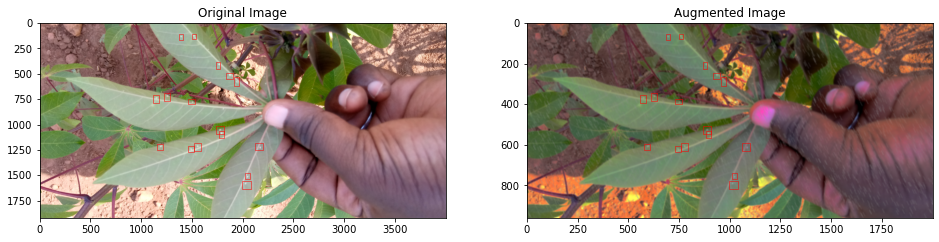

In [55]:

    aug = albumentations.Compose([
      albumentations.Resize(960, 2000),   # Resize the given 1920 x 4000 image to 960* 2000   
      albumentations.RandomRain(p=1)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
aug_result = aug(image=image, bboxes=pascal_voc_boxes, labels=labels)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 16))
get_bbox(pascal_voc_boxes, ax[0], color='red')
ax[0].title.set_text('Original Image')
ax[0].imshow(image)

get_bbox(aug_result['bboxes'], ax[1], color='red')
ax[1].title.set_text('Augmented Image')
ax[1].imshow(aug_result['image'])
plt.show()

In [ ]:
https://www.kaggle.com/whurobin/data-augmentation-test-with-albumentations